In [ ]:
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!nvidia-smi

Tue Jun  8 06:00:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    37W / 300W |   1033MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Auswahl des Spiels

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [ ]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

In [ ]:
try: 
    env = gym.make(game)
except:
    from google.colab import drive
    drive.mount('/content/drive')
    !python -m atari_py.import_roms "drive/MyDrive/Atari_Roms"
    env = gym.make(game)

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


## Fire Wrapper

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

## Max And Skip Env Wrapper

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

## Noop Reset Env Wrapper

In [ ]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

## Scaled Float Frame Wrapper

In [ ]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

## Episodic Life Wrapper

In [ ]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

## Clip Reward Wrapper

In [ ]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

## Resize & Grayscale Wrapper

In [ ]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

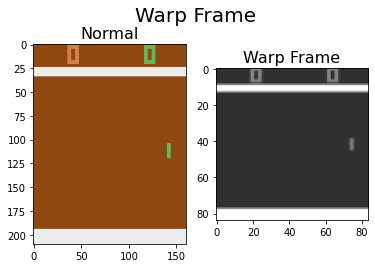

In [ ]:
""" 
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

## Frame Stack Wrapper

In [ ]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

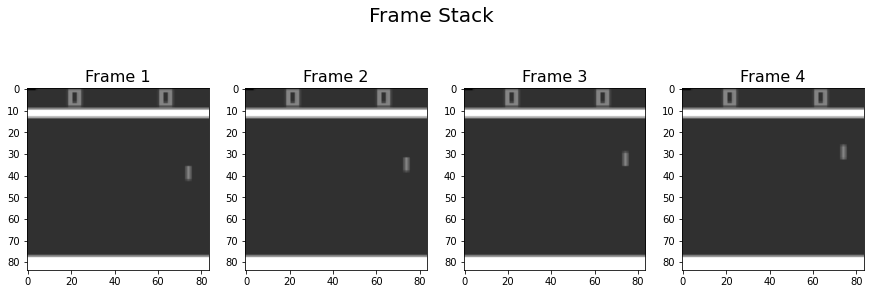

In [ ]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

## Erstellen des Environments

In [ ]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

""" saving the properties for csv """

MODE = "NoEpisodicLife_NoClipReward_lr_1e-3_5e-3"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Pong-v0/NoEpisodicLife_NoClipReward_lr_1e-3_5e-3/


# Actor Network und Critic Network

In [ ]:
from tensorflow.keras import backend as K


# PPO Loss
def ppo(y_true, y_pred):
    advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+env.action_space.n], y_true[:, 1+env.action_space.n:]

    LOSS_CLIPPING = 0.2
    ENTROPY_LOSS = 5e-3

    prob = y_pred * actions
    old_prob = actions * prediction_picks
    r = prob/(old_prob + 1e-10)
    p1 = r * advantages
    p2 = K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages
    loss =  -K.mean(K.minimum(p1, p2) + ENTROPY_LOSS * -(prob * K.log(prob + 1e-10)))
    return loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Network Parameter
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
ACTOR_OUTPUT = env.action_space.n # Anzahl der möglichen Aktionen
CRITIC_OUTPUT = 1 # Bewertung der gewählten Aktion
ACTOR_LEARNING_RATE = 25e-6
CRITIC_LEARNING_RATE = 25e-6

# neuronales Netz
net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)


'''Aufspalten des Netzes in Actor und Critic'''

# Actor - wählt eine Aktion
actor_x = Dense(ACTOR_OUTPUT)(x)
actor_output = Activation("softmax")(actor_x)

ACTOR = Model(inputs=net_input, outputs=actor_output)
ACTOR.compile(loss=ppo, optimizer=Adam(lr=ACTOR_LEARNING_RATE))

# Critic - bewertet gewählte Aktion
critic_x = Dense(CRITIC_OUTPUT)(x)
critic_output = Activation("linear")(critic_x)

CRITIC = Model(inputs=net_input, outputs=critic_output)
CRITIC.compile(loss="mse", optimizer=Adam(lr=CRITIC_LEARNING_RATE))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Aktion wählen

In [ ]:
def get_action(state):
    prediction = ACTOR.predict(state)[0]
    action = np.random.choice(env.action_space.n, p=prediction) # Aktionen, welche Wahrscheinlichkeit zu Aktion
    return action, prediction

In [ ]:
def remember (state, action, reward, prediction):
    STATES.append(state)
    # Erstellen eines One Hot Labels für die Aktion
    action_onehot = np.zeros([env.action_space.n])
    action_onehot[action] = 1
    ACTIONS.append(action_onehot)
    REWARDS.append(reward)
    PREDICTIONS.append(prediction)

In [ ]:
def discount_rewards(rewards):
    gamma = 0.99
    running_add = 0
    discounted_r = np.zeros_like(rewards)
    for i in reversed(range(0, len(rewards))):
        if rewards[i] != 0: # Pong
            running_add = 0
        running_add = running_add * gamma + rewards[i]
        discounted_r[i] = running_add

    discounted_r -= np.mean(discounted_r) # normalisieren
    discounted_r /= np.std(discounted_r) # teilen durch Standardabweichung

    return discounted_r

In [ ]:
def replay(STATES, ACTIONS, REWARDS, PREDICTIONS):
    states = np.vstack(STATES)
    actions = np.vstack(ACTIONS)
    predictions = np.vstack(PREDICTIONS)

    # discount rewards
    discounted_r = np.vstack(discount_rewards(REWARDS))

    # Critic predictions
    values = CRITIC.predict(states)

    # Advantagewerte berechnen
    advantages = discounted_r - values

    y_true = np.hstack([advantages, predictions, actions])

    # Trainieren der Netzwerke ACTOR und CRITIC
    ACTOR.fit(states, y_true, epochs=1, verbose=0, batch_size=len(REWARDS))
    CRITIC.fit(states, discounted_r, epochs=1, verbose=0, batch_size=len(REWARDS))

    # leeren des Episoden Buffers
    STATES, ACTIONS, REWARDS, PREDICTIONS = [], [], [], []

# Training /Spielen

In [ ]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-19.0

In [ ]:
EPISODES = 15_000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False

    # Episoden Buffer
    STATES, ACTIONS, REWARDS, PREDICTIONS = [], [], [], []
    
    while not done:        
        action, prediction = get_action(state)
        
        next_state, reward, done, _ = env.step(action)
        
        # Transition im Episoden Buffer speichern
        remember(state, action, reward, prediction)

        # aktualisieren des States
        state = next_state
        
        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward


        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD)

            # Übernahme des höchsten Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # trainierte Gewichte speichern
                import os
                try:
                    os.makedirs(PATH)
                except FileExistsError:
                    # Pfad existiert bereits
                    pass
                ACTOR.save_weights(PATH + "Best_ACTOR.h5")
                CRITIC.save_weights(PATH + "Best_CRITIC.h5")

            replay(STATES, ACTIONS, REWARDS, PREDICTIONS)

Episode: 1 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 5 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 6 	Reward: -21.0 	Mean: -20.33 	BestMean: -19.0
Episode: 7 	Reward: -20.0 	Mean: -20.29 	BestMean: -19.0
Episode: 8 	Reward: -20.0 	Mean: -20.25 	BestMean: -19.0
Episode: 9 	Reward: -21.0 	Mean: -20.33 	BestMean: -19.0
Episode: 10 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 11 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 12 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 13 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 14 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 15 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 16 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 17 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 18 	Reward: -20.0 	Mean: -2

In [ ]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST)), 
               columns =['Rewards', 'Mean Reward']) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [ ]:
ACTOR.save_weights(PATH + "End.h5")
CRITIC.save_weights(PATH + "End.h5")

# Auswertung

In [ ]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Spielen

In [ ]:
import gym
from IPython import display
import matplotlib

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(ACTOR.predict(state))
        state, reward, done, info = env.step(action)